In [ ]:
%pip install -q -U --no-warn-conflicts malariagen_data
%pip install -q --no-warn-conflicts petl

In [2]:
import malariagen_data
import allel
import numpy as np
import numba
from numba import njit
import pandas as pd
import functools
#import dask
from dask.diagnostics.progress import ProgressBar
#dask.config.set(**{'array.slicing.split_large_chunks': True})
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
from matplotlib.legend import Legend
#import matplotlib_venn as venn
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [3]:
import scipy
import scipy.cluster
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance
from scipy.cluster.hierarchy import _hierarchy

In [4]:
#Mounting Google Drive
import os
from google.colab import drive
drive.mount("drive")

# make dir
results_dir = "drive/MyDrive"
os.makedirs(results_dir, exist_ok=True)

Mounted at drive


In [5]:
## Importing malariagen data set
ag3 = malariagen_data.Ag3("gs://vo_agam_release_master_us_central1/", pre=True)
ag3

<MalariaGEN Ag3 API client>
Storage URL             : gs://vo_agam_release_master_us_central1/
Data releases available : 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 3.10, 3.11, 3.12, 3.13, 3.14, 3.15
Results cache           : None
Cohorts analysis        : 20250131
AIM analysis            : 20220528
Site filters analysis   : dt_20200416
Software version        : malariagen_data 15.2.2
Client location         : Iowa, United States (Google Cloud us-central1)
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact support@malariagen.net. For API documentation see 
https://malariagen.github.io/malariagen-data-python/v15.2.2/Ag3.html

In [6]:
df_samples=ag3.sample_metadata(sample_sets='3.11', sample_query='country=="Burkina Faso"')
sets = list(df_samples.sample_set.unique())

In [7]:
## transcrit and region
region = "2R:3483099-3497400"
transcript = 'AGAP001356-RA'

#To access to the genotypes within the 3L chromosomes
ds_snps = ag3.snp_calls(region="2R:3483099-3497400", sample_sets=sets)

# Take some SNP in the X chromosomes
ds_pos = allel.SortedIndex(ds_snps['variant_position'].values)

# To filter the SNP dataset and warp the dataset to GT array
filt = 'gamb_colu_arab'
filt_val = ds_snps[f"variant_filter_pass_{filt}"].values

## Compute genotype & count the number of alleles
with ProgressBar():
  ds_gt = allel.GenotypeArray(ds_snps["call_genotype"][filt_val].data)
  ds_ac = ds_gt.count_alleles()

[########################################] | 100% Completed | 1.22 s


## Diplotype clustering

In [8]:
diplo_d = ag3.diplotype_pairwise_distances(region=region,sample_query='country=="Burkina Faso"',
                                           sample_sets=sets, site_mask='gamb_colu_arab',
                                           distance_metric='euclidean')

Load genotypes for distance calculation:   0%|          | 0/58 [00:00<?, ?it/s]

In [116]:
method='complete'
y = np.asarray(diplo_d[0], order='c', dtype=np.double)
n = int(distance.num_obs_y(diplo_d[0]))
method = dict(single=0, complete=1)[method]
z_clust1 = scipy.cluster.hierarchy.linkage(y, method='complete')

In [117]:
z_clust = scipy.cluster.hierarchy.linkage(diplo_d[0], method='complete')

In [11]:
from scipy.cluster.hierarchy import dendrogram, fcluster, leaves_list, set_link_color_palette

In [12]:
#fcluster(z_clust1, t=0.1, criterion='distance')

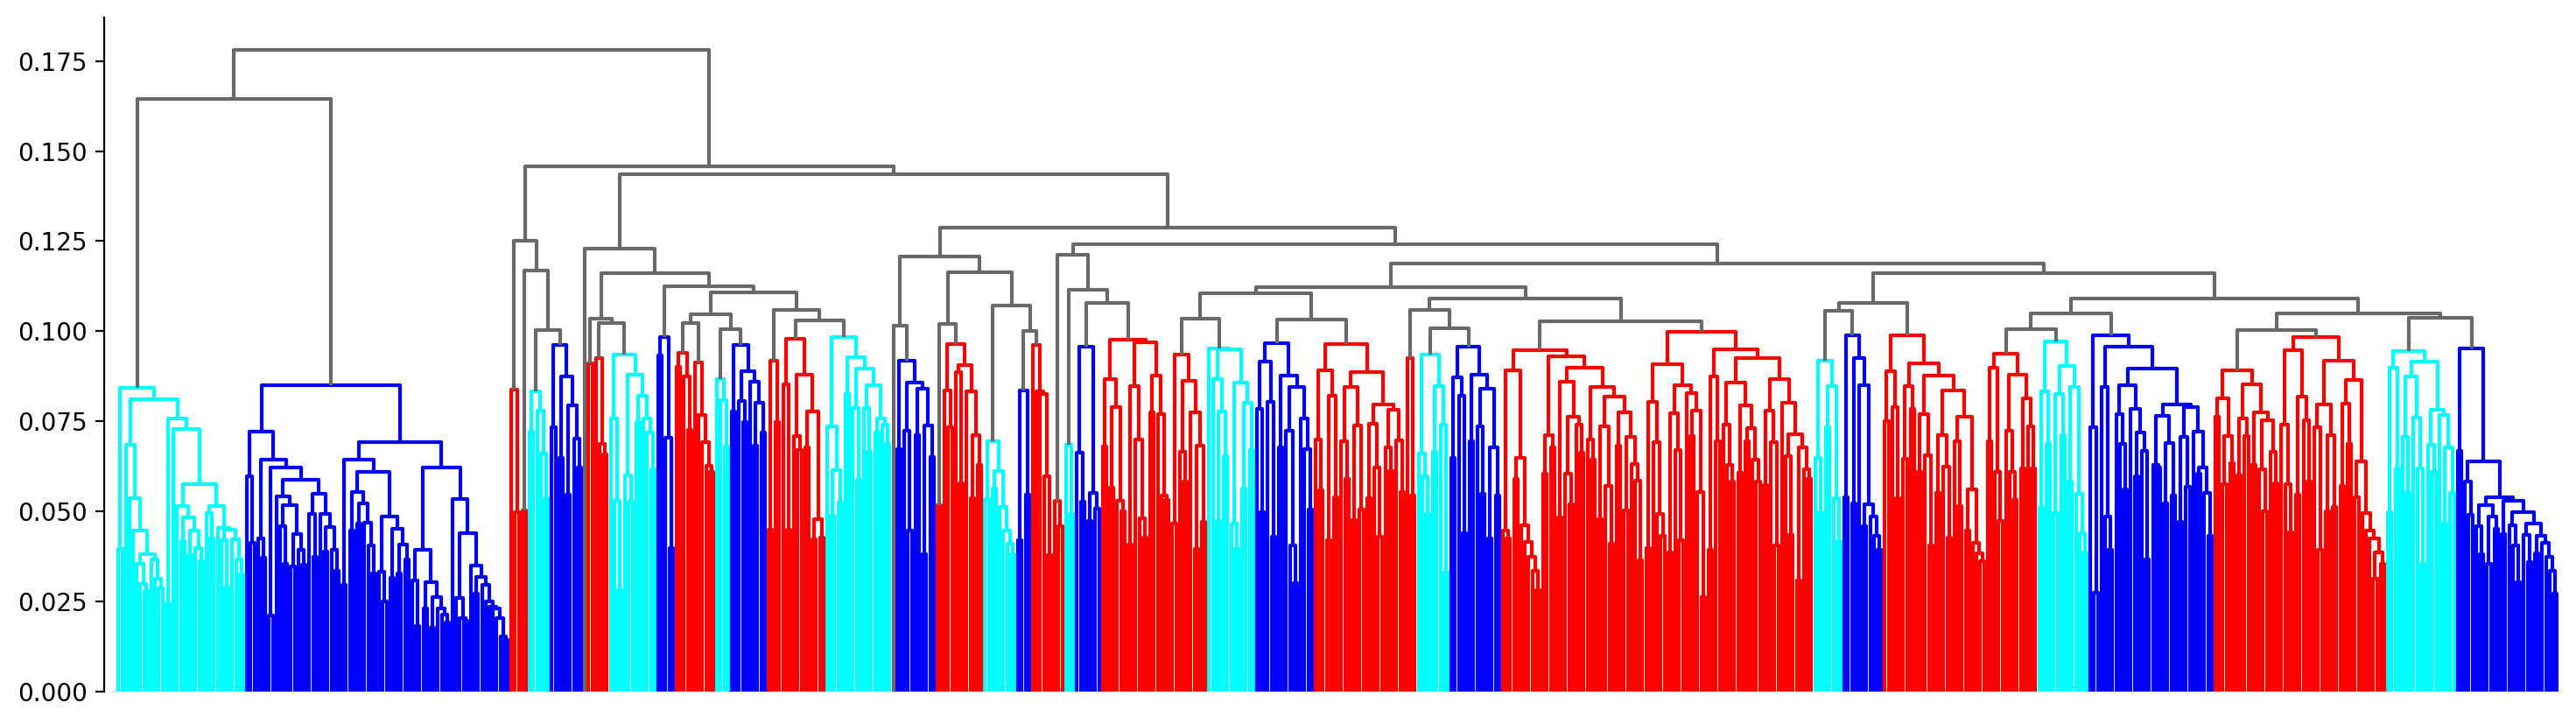

In [104]:
fig, ax = plt.subplots(figsize=(18, 5))
set_link_color_palette(['cyan','blue','red','red'])
sns.despine(ax=ax, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z_clust1, count_sort=True, ax=ax, color_threshold=0.1, no_labels=True,
                                          above_threshold_color='dimgrey')

### samples handling, heterozygoty and SNP freq

In [14]:
leaves = dend['leaves']
leaf_data = df_samples.copy().iloc[leaves]
leaf_data['pop_location'] = [z+', '+y for z, y in zip(leaf_data.location, leaf_data.aim_species)]
leaf_list = list(leaf_data['sample_id'])
color_l = dend['leaves_color_list']

leaf_y, n_leaves = 0, len(leaves)
leaf_data['dx'] = np.arange(n_leaves)
leaf_data['dy'] = np.repeat(leaf_y, n_leaves)
leaf_data['dy1'] = np.repeat(0.5, n_leaves)
#leaf_data['dy2'] = np.repeat(leaf_y-0.2, n_leaves)
#leaf_data['dy12'] = np.repeat(-0.01, n_leaves)
pop_ids = list(leaf_data.aim_species.unique())
colored, pop_colors = sns.color_palette("husl", len(pop_ids)), {}
for i in range(len(pop_ids)):
    pop_colors[pop_ids[i]] = colored[i]

In [15]:
het_per_sample = ds_gt.take(leaves).is_het().sum(axis=0) / ds_gt.take(leaves).is_called().sum(axis=0)
df_het = pd.DataFrame({'sample_id': leaf_list, 'heterozigosity': het_per_sample}).set_index('sample_id')
df_het = df_het.loc[leaf_data['sample_id'].to_list(), :].T

In [89]:
df_snps1 = ag3.snp_genotype_allele_counts(transcript=transcript,sample_sets=sets, site_mask='gamb_colu_arab')
df_snps2 = df_snps1.query("effect == ['NON_SYNONYMOUS_CODING', 'START_LOST', 'STOP_LOST', 'STOP_GAINED']")
df_snps3 = df_snps2.set_index('label')
df_snps4 = df_snps3.filter(like='count_').loc[:,['count_'+ s for s in leaf_list]]
df_snps5 = df_snps4.assign(af=lambda x: x.sum(axis=1) / (x.shape[1] * 2))
dfs_snps = df_snps5.query("af > 0.01").drop(columns="af")

Load SNP genotypes:   0%|          | 0/28 [00:00<?, ?it/s]

Compute SNP effects:   0%|          | 0/42906 [00:00<?, ?it/s]

### Plot clustering

In [107]:
## Costum colors
legend_tips = {'gambiae':["o",0,'darkred'],'coluzzii':["X",1,'magenta'],'arabiensis':["D",2,'navy'],
               'intermediate_gambcolu_arabiensis':['v',3,'darkgoldenrod'],'intermediate_gambiae_coluzzii':['v',3,'darkgoldenrod']}
sp_col = ['darkred','magenta','navy','darkgoldenrod']
ag_dict = {'gambiae':'An. gambiae s.s.','coluzzii':'An. coluzzii','arabiensis':'An. arabiensis',
           'intermediate_gambcolu_arabiensis':'hybrid'}
leg_values = [legend_tips[i][1] for i in leaf_data.aim_species]
leg_labels = ['An. gambiae s.s.', 'An. coluzzii', 'An. arabiensis', 'hybrid']
color_maps = mpl.colors.ListedColormap([legend_tips[i][2] for i in list(legend_tips.keys())[:-1]])
color_maps1 = hap_color = [legend_tips[i][2] for i in leaf_data.aim_species]

In [18]:
#plt.broken_barh(xranges=[(i, 1) for i in range(leaf_data.shape[0])], yrange=(0, 1), color=hap_color)
#plt.xlim(0,n_leaves)
#plt.axis('off')

In [19]:
#haplo_maps

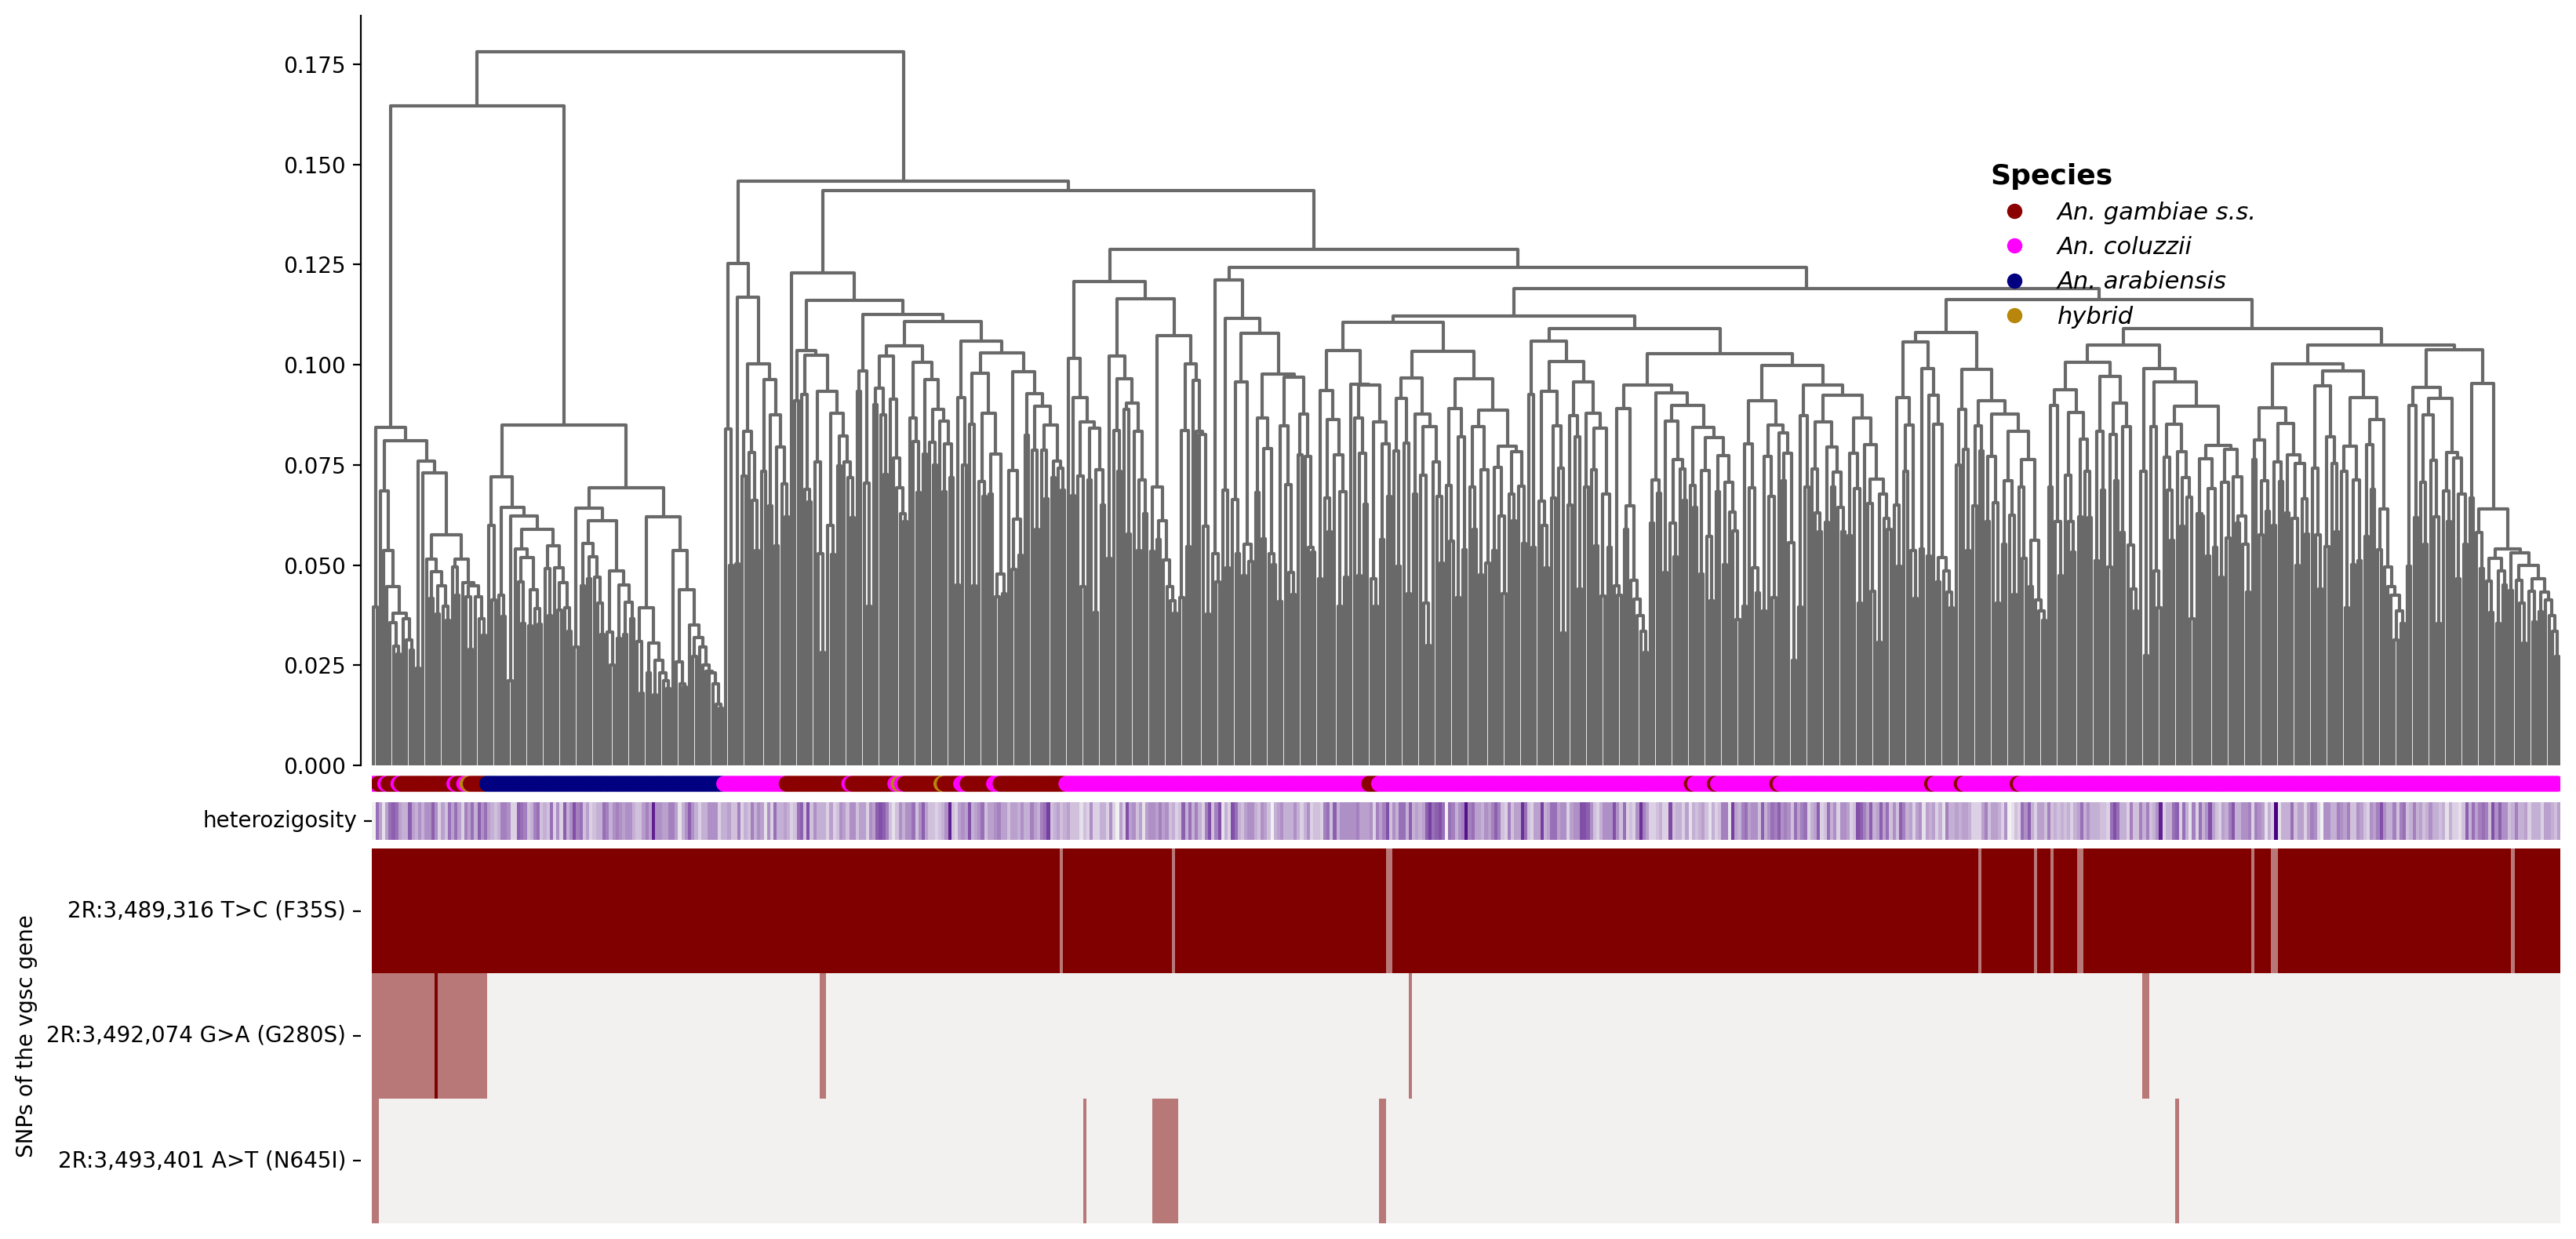

In [105]:
fig = plt.figure(figsize=(18,10))
gs = GridSpec(4, 1, hspace = 0.03, height_ratios=(2,0.05,0.1,1))

ax0 = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z_clust, count_sort=True, ax=ax0, color_threshold=0, no_labels=True,
                                          above_threshold_color='dimgrey')
ax1 = plt.subplot(gs[1, 0])
ax_fig = ax1.scatter(leaf_data.dx, leaf_data.dy, s=40,c=leg_values, cmap=color_maps)
handles, labels = ax_fig.legend_elements()
plt.xlim(0,n_leaves)
plt.axis('off')

ax2 = plt.subplot(gs[2, 0])
ax2=sns.heatmap(data=df_het, cmap=sns.light_palette("indigo", as_cmap=True), xticklabels=[], cbar=False)
ax2.set(xlabel=' ', ylabel=' ')
plt.yticks(rotation=0)

ax3 = plt.subplot(gs[3, 0])
sns.despine(ax=ax3, offset=5,bottom=True)
sns.heatmap(data=dfs_snps, cmap=sns.light_palette("maroon", as_cmap=True), xticklabels=[],
            cbar=False, ax=ax3)
ax3.set(xlabel='', ylabel='SNPs of the vgsc gene')
fig.legend(title='Species', labels=leg_labels, handles=handles,bbox_to_anchor=(0.8, 0.8),frameon=False,
          prop={'size':11, 'style': 'italic'}, title_fontproperties={'size':13, 'weight':'bold'}, alignment='left')


plt.show()
#fig.savefig(fname='drive/MyDrive/sanger_analyses/resistance/clust_fig.png',dpi=300, bbox_inches='tight')

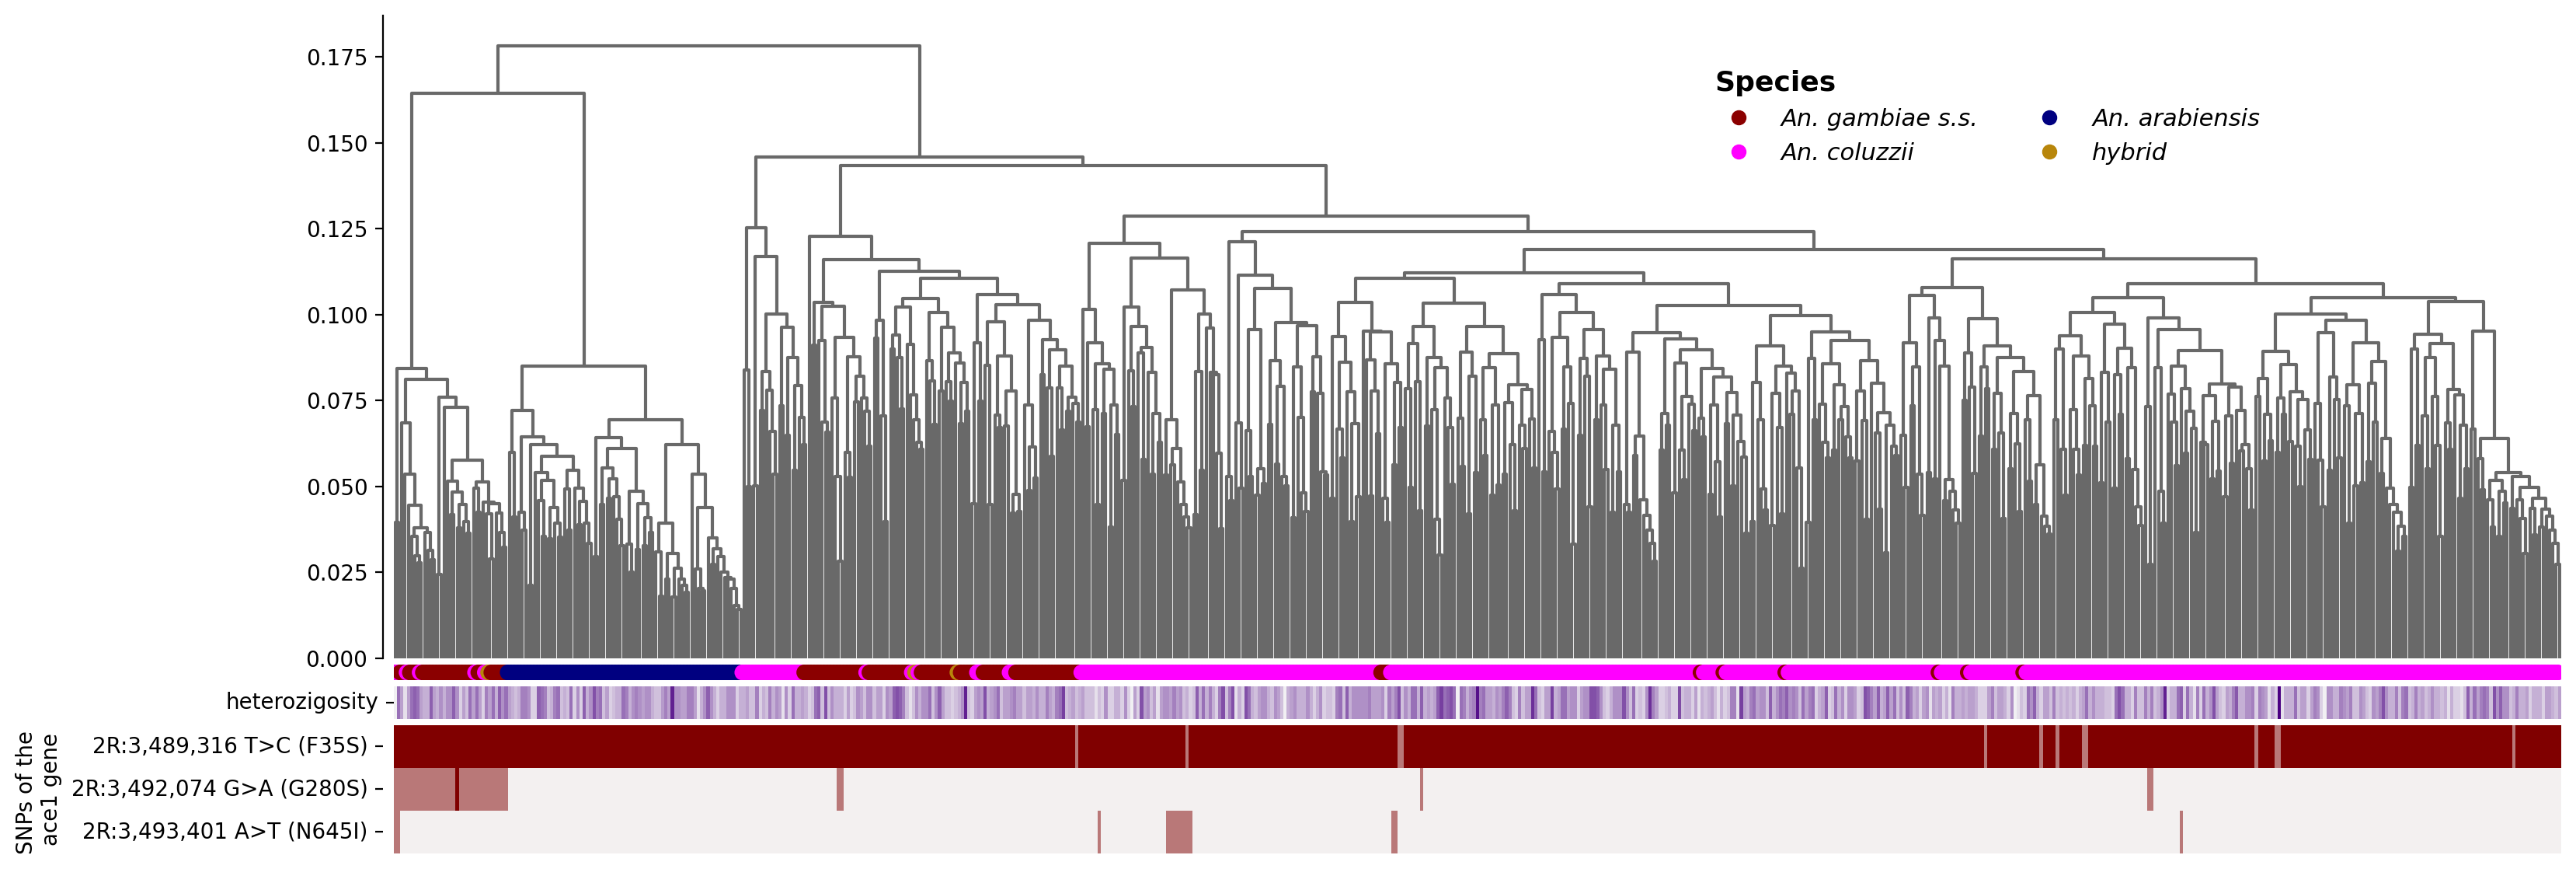

In [21]:
fig = plt.figure(figsize=(18,7))
gs = GridSpec(4, 1, hspace = 0.03, height_ratios=(2,0.05,0.1,0.4))

ax0 = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z_clust1, count_sort=True, ax=ax0, color_threshold=0, no_labels=True,
                                          above_threshold_color='dimgrey')
ax1 = plt.subplot(gs[1, 0])
ax_fig = ax1.scatter(leaf_data.dx, leaf_data.dy, s=40,c=leg_values, cmap=color_maps)
handles, labels = ax_fig.legend_elements()
plt.xlim(0,n_leaves)
plt.axis('off')

ax2 = plt.subplot(gs[2, 0])
ax2=sns.heatmap(data=df_het, cmap=sns.light_palette("indigo", as_cmap=True), xticklabels=[], cbar=False)
ax2.set(xlabel=' ', ylabel=' ')
plt.yticks(rotation=0)

ax3 = plt.subplot(gs[3, 0])
sns.despine(ax=ax3, offset=5,bottom=True)
sns.heatmap(data=dfs_snps, cmap=sns.light_palette("maroon", as_cmap=True), xticklabels=[],
            cbar=False, ax=ax3)
ax3.set(xlabel='', ylabel='SNPs of the \nace1 gene')
fig.legend(title='Species', labels=leg_labels, handles=handles,bbox_to_anchor=(0.8, 0.85),frameon=False,
          prop={'size':11, 'style': 'italic'}, title_fontproperties={'size':13, 'weight':'bold'},
           alignment='left', ncol=2)


plt.show()
fig.savefig(fname='drive/MyDrive/sanger_analyses/resistance/ACE1/clust_fig.png',dpi=300, bbox_inches='tight')

## Add CNV

In [42]:
## read CNV tables
cnv_hmm = pd.read_csv('drive/MyDrive/sanger_analyses/resistance/CNV/data/cnv_df_hmm.csv').drop(['Unnamed: 0'],axis=1)
#cnv_hmm.head()

## select genes tables
gene = 'AGAP001356'
cnv_select = cnv_hmm.query('gene_id == @gene')
cnv_select.shape

(493, 15)

In [99]:
## Warp and select CNV data tables
samles_list = []
sample_list = cnv_select.sample_id.to_list()
for sample in leaf_list:
  if sample not in sample_list:
    samles_list.append(sample)
print(len(samles_list))
np.repeat(0, len(samles_list))
dfi = pd.DataFrame({'sample_id': samles_list, 'CN_mode': np.repeat(0, len(samles_list))})

##
cnv_dfi = cnv_select[['sample_id','CN_mode']]

## Concat tables
cnv_dfii = pd.concat([cnv_dfi, dfi])
print(cnv_dfii.shape)

## sort values
cnv_dfii['sample_id'] = pd.Categorical(cnv_dfii['sample_id'], categories=leaf_list)
cnv_dfii = cnv_dfii.sort_values('sample_id')
cnv_dfii['sample_id1'] = ['count_'+ s for s in cnv_dfii['sample_id']]
cnv_dfii.sample_id1.to_list() == dfs_snps.columns

## rename col
cnv_dfii.rename(columns={'CN_mode':'ACE1_amp'}, inplace=True)

## index
cnv_df = cnv_dfii[['sample_id1','ACE1_amp']]
cnv_df.set_index('sample_id1', inplace=True)
cnv_df = cnv_df.T
cnv_df.head()

## concat two dfs
df_cnv_snp = pd.concat([dfs_snps, cnv_df])

172
(665, 2)


## Diplotypes

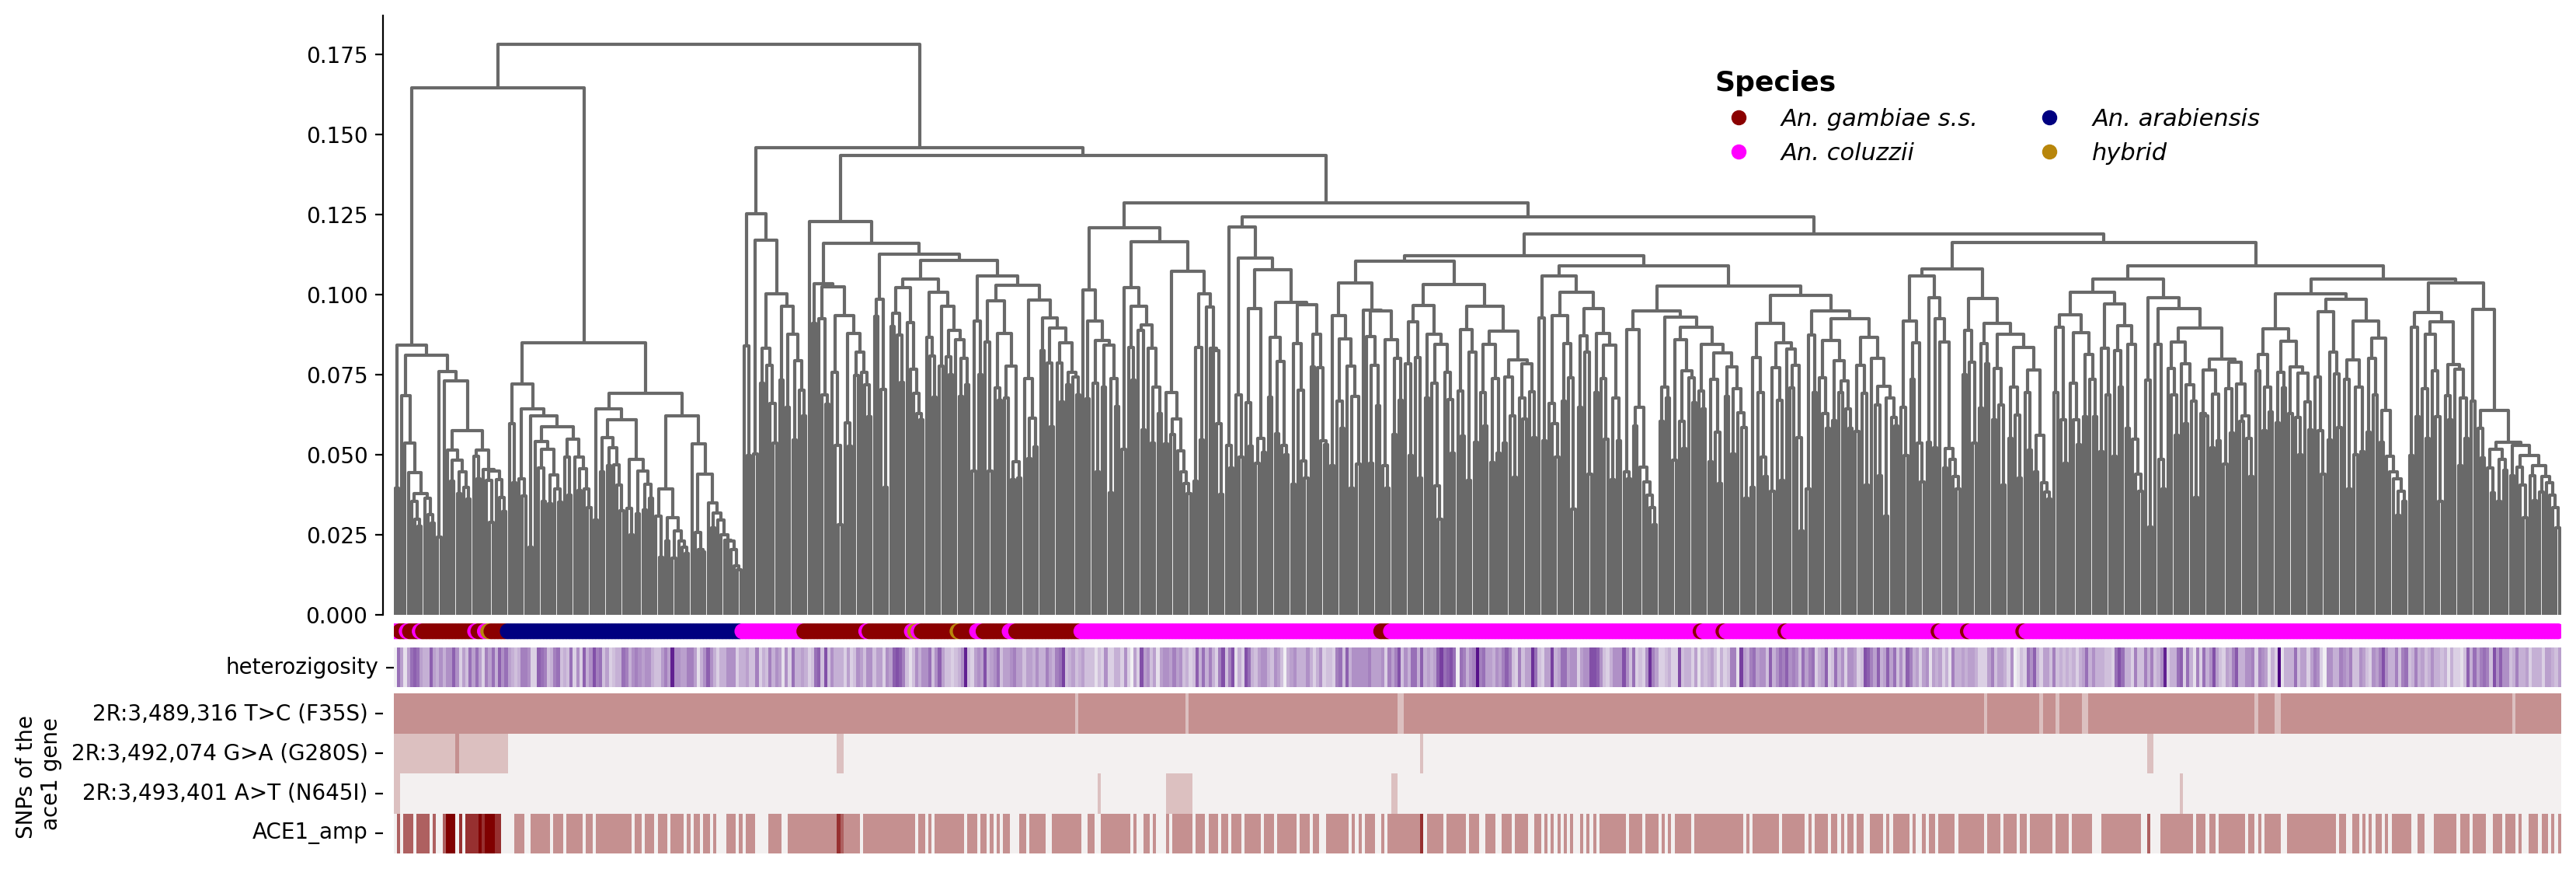

In [106]:
fig = plt.figure(figsize=(18,7))
gs = GridSpec(4, 1, hspace = 0.03, height_ratios=(1.5,0.05,0.1,0.4))

ax0 = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z_clust1, count_sort=True, ax=ax0, color_threshold=0, no_labels=True,
                                          above_threshold_color='dimgrey')
ax1 = plt.subplot(gs[1, 0])
ax_fig = ax1.scatter(leaf_data.dx, leaf_data.dy, s=40,c=leg_values, cmap=color_maps)
handles, labels = ax_fig.legend_elements()
plt.xlim(0,n_leaves)
plt.axis('off')

ax2 = plt.subplot(gs[2, 0])
ax2=sns.heatmap(data=df_het, cmap=sns.light_palette("indigo", as_cmap=True), xticklabels=[], cbar=False)
ax2.set(xlabel=' ', ylabel=' ')
plt.yticks(rotation=0)

ax3 = plt.subplot(gs[3, 0])
sns.despine(ax=ax3, offset=5,bottom=True)
sns.heatmap(data=df_cnv_snp, cmap=sns.light_palette("maroon", as_cmap=True), xticklabels=[],
            cbar=False, ax=ax3)
ax3.set(xlabel='', ylabel='SNPs of the \nace1 gene')
fig.legend(title='Species', labels=leg_labels, handles=handles,bbox_to_anchor=(0.8, 0.85),frameon=False,
          prop={'size':11, 'style': 'italic'}, title_fontproperties={'size':13, 'weight':'bold'},
           alignment='left', ncol=2)


plt.show()
#fig.savefig(fname='drive/MyDrive/sanger_analyses/resistance/ACE1/clust_cnv_fig.png',dpi=300, bbox_inches='tight')

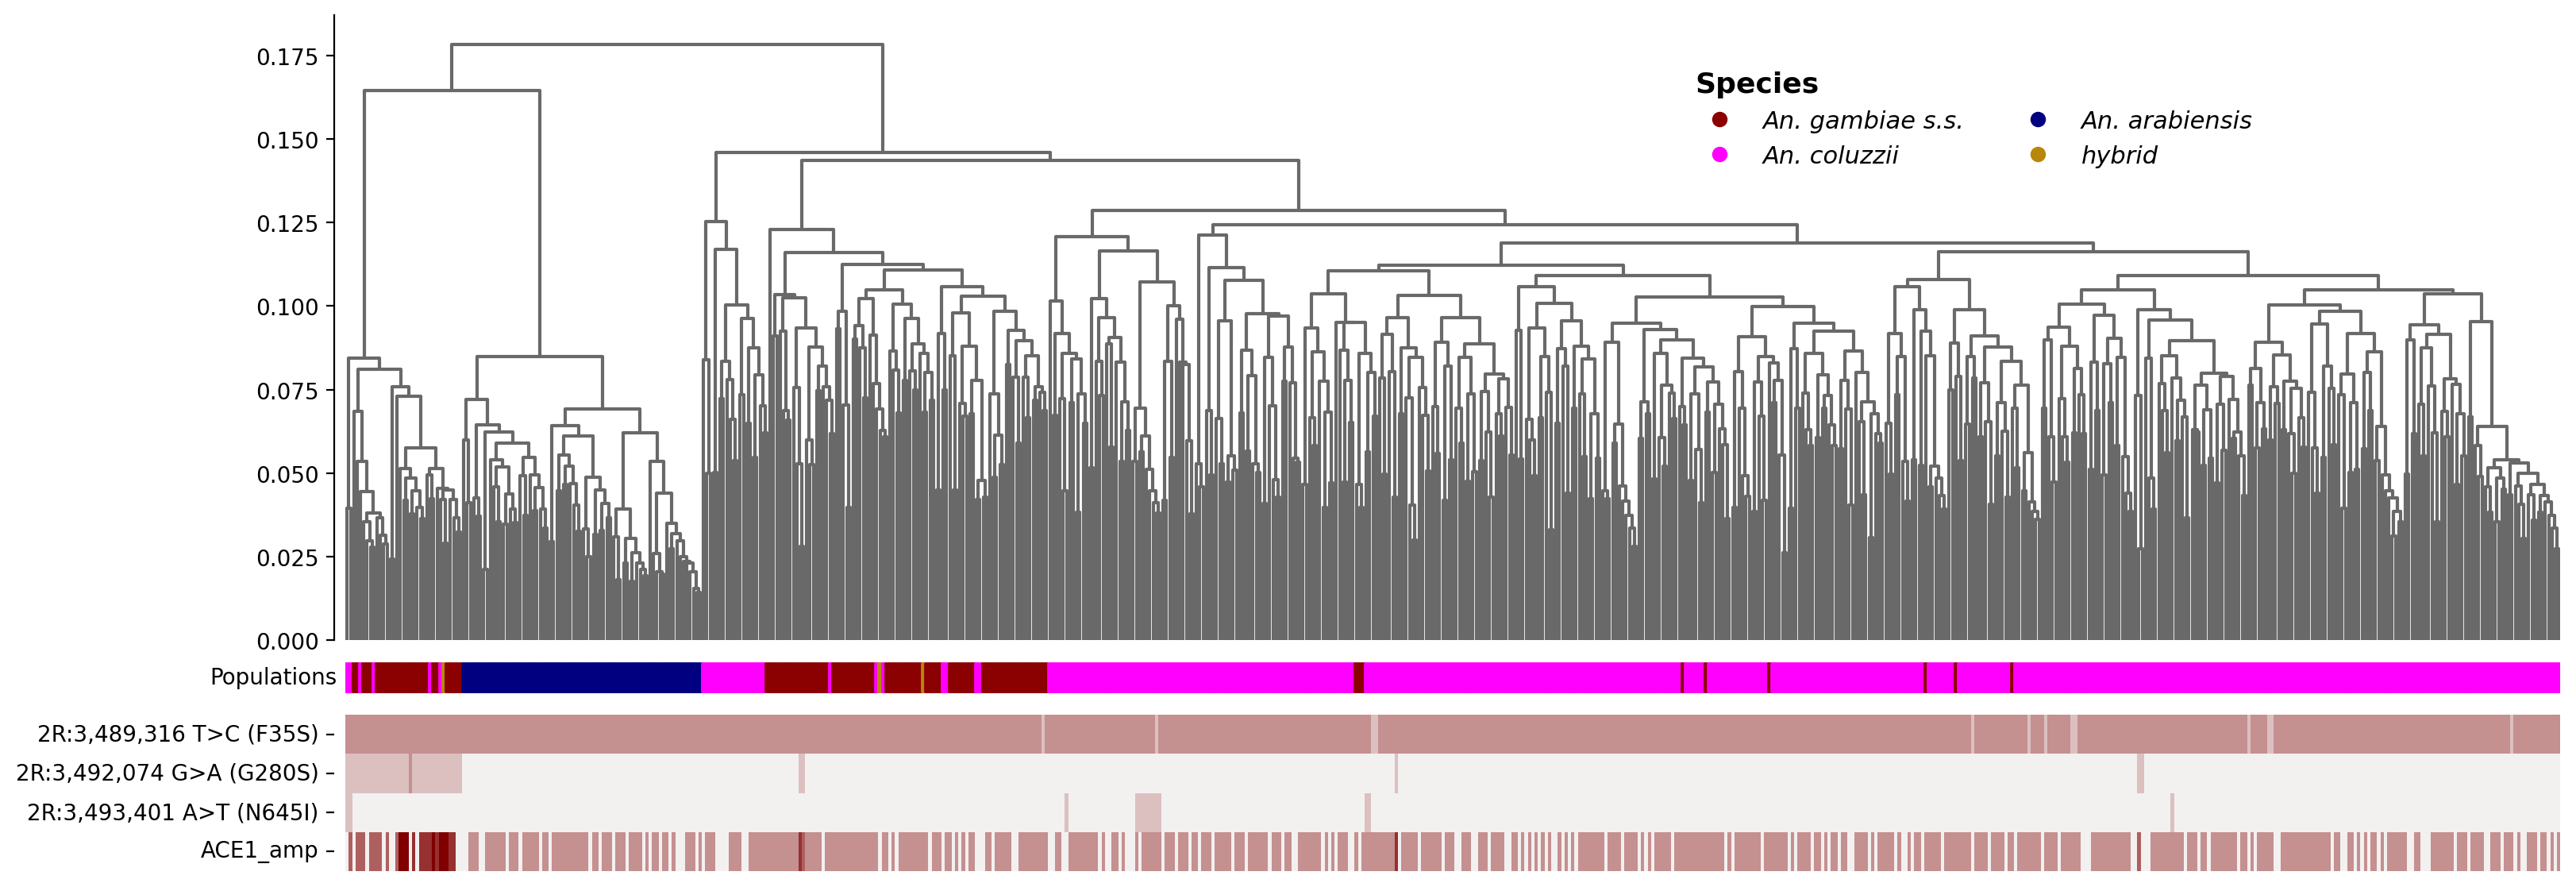

In [121]:
fig = plt.figure(figsize=(18,7))
gs = GridSpec(3, 1, hspace = 0.08, height_ratios=(1,0.05,0.25))

ax0 = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z_clust1, count_sort=True, ax=ax0, color_threshold=0, no_labels=True,
                                          above_threshold_color='dimgrey')
ax1 = plt.subplot(gs[1, 0])
ax1.broken_barh(xranges=[(i, 1) for i in range(leaf_data.shape[0])], yrange=(0, 1), color=color_maps1)
ax1.set_xlim(0,n_leaves)
sns.despine(ax=ax1, offset=5, left=True, bottom=True)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.yaxis.set_label_position('left')
#plt.axis('off')
ax1.set_ylabel('Populations',rotation=0, ha='right', va='center')

ax2 = plt.subplot(gs[2, 0])
sns.despine(ax=ax2, offset=5,bottom=True)
sns.heatmap(data=df_cnv_snp, cmap=sns.light_palette("maroon", as_cmap=True), xticklabels=[],
            cbar=False, ax=ax2)
ax3.set(xlabel='', ylabel='SNPs of the \nace1 gene')
fig.legend(title='Species', labels=leg_labels, handles=handles,bbox_to_anchor=(0.8, 0.85),frameon=False,
          prop={'size':11, 'style': 'italic'}, title_fontproperties={'size':13, 'weight':'bold'},
           alignment='left', ncol=2)


plt.show()
#fig.savefig(fname='drive/MyDrive/sanger_analyses/resistance/ACE1/clust_cnv_fig.png',dpi=300, bbox_inches='tight')